# Libs

In [ ]:
# 기본 데이터 처리 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_columns', None)

# 로그 및 경고 처리
import logging
import warnings
warnings.filterwarnings('ignore')  # 경고 무시
import ray

# 머신러닝 및 데이터 전처리 라이브러리
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error

# 머신러닝 알고리즘
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier  # 사용시 주석 해제

# 데이터 불균형 처리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 지리 정보 처리 라이브러리
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# DuckDB 데이터베이스 연결
import duckdb

# UDM

In [2]:
def mk_pnt(x):
    return Point(x['X좌표'], x['Y좌표'])

# read data

In [3]:
df = pd.read_csv('../../KoRoad/TAAS/교통사고DATA_2018_2023.csv',encoding='cp949', low_memory=False)

In [21]:
df.head(1)

,TAAS사고번호,발생일시,발생년,발생월,발생일,발생시,주야,주야_코드,요일,요일_코드,발생시도,발생시도_코드,발생시군구,발생시군구_코드,발생경찰청,발생경찰청_코드,발생경찰서,발생경찰서_코드,X좌표,Y좌표,기상상태,기상상태_코드,노면상태,노면상태_코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형_대분류,사고유형_중분류,사고유형,사고유형_코드,뺑소니,역주행,개문발차,긴급자동차,군용차,도로내동물사고,대리운전,전기자동차,가해자국적,피해자국적,가해자주거지시도,가해자주거지시군구,가해자주거지시군구_코드,피해자주거지시도,피해자주거지시군구,피해자주거지시군구_코드,가해자성별,피해자성별,가해자연령,가해자연령_수치,피해자연령,피해자연령_수치,가해자학생사고_대분류,가해자학생사고,가해자학생사고_코드,피해자학생사고_대분류,피해자학생사고,피해자학생사고_코드,가해자운전면허종류_대분류,가해자운전면허종류,가해자운전면허종류_코드,피해자운전면허종류_대분류,피해자운전면허종류,피해자운전면허종류_코드,가해자운전면허경과년수_대분류,가해자운전면허경과년수,피해자운전면허경과년수_대분류,피해자운전면허경과년수,가해자보호장구착용여부_대분류,가해자보호장구착용여부,가해자보호장구착용여부_코드,피해자보호장구착용여부_대분류,피해자보호장구착용여부,피해자보호장구착용여부_코드,가해자신체상해정도,가해자신체상해정도_코드,피해자신체상해정도,피해자신체상해정도_코드,과속사고,가해자음주측정수치_대분류,가해자음주측정수치,가해자음주측정수치_코드,피해자음주측정수치_대분류,피해자음주측정수치,피해자음주측정수치_코드,가해자법규위반_대분류,가해자법규위반_중분류,가해자법규위반,가해자법규위반_중과실,피해자법규위반_대분류,피해자법규위반_중분류,피해자법규위반,피해자법규위반_중과실,가해자행동유형_대분류,가해자행동유형_중분류,가해자행동유형,가해자행동유형_코드,피해자행동유형_대분류,피해자행동유형_중분류,피해자행동유형,피해자행동유형_코드,가해자신체상해주부위_대분류,가해자신체상해주부위,가해자신체상해주부위_코드,피해자신체상해주부위_대분류,피해자신체상해주부위,피해자신체상해주부위_코드,가해자차종,가해자차종_코드,피해자차종,피해자차종_코드,가해자보험가입상황,피해자보험가입상황,가해자차량용도_대분류,가해자차량용도_중분류,가해자차량용도,가해자차량용도_코드,피해자차량용도_대분류,피해자차량용도_중분류,피해자차량용도,가해자차량용도_코드_1,도로종류,도로종류_코드,고속도로번호,고속도로번호_1,도로형태_대분류,도로형태,도로형태_코드,교차로형태_대분류,교차로형태,교차로형태_코드,도로선형_대분류,도로선형_중분류,도로선형,도로선형_코드,중앙분리시설,보차도분리시설,자동차전용도로,중앙버스전용차로,가로변버스전용차로,자전거전용도로,자전거우선도로,자전거전용차로,자전거보행자겸용도로,가변차로,하이패스차로,일방통행도로,어린이보호구역,노인보호구역,장애인보호구역,구역30,고속도로도로위치,대형사고여부,사망사고여부,중상사고여부,경상사고여부,부상신고사고여부,음주운전사고여부,여성운전자사고여부,차대사람사고여부,차대차사고여부,차량단독사고여부,횡단보도사고여부,교차로사고여부,일반국도사고여부,고속국도사고여부,버스전용차로사고여부,사업용차량사고여부,비사업용차량사고여부,화물차사고여부,이륜차사고여부,택시사고여부,시내버스사고여부,뺑소니사고여부,무면허운전사고여부,무보험차량사고여부,연령별어린이사고여부,보행어린이사고여부,어린이보호구역사고여부,학년별어린이사고여부,고령층사고여부,고령운전자사고여부,중상이상사고여부
0,2020010100100080,2020010106,2020,1,1,6,주,1,수,4,서울,1100,중구,1100,서울경찰청,1101,서울중부,1101,127.015945,37.569626,흐림,2,건조,1,경상,0,0,2,0,차대차,측면충돌,측면충돌,22,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,한국,한국,서울,노원구,1122,서울,동대문구,1105,남,남,60세,60,43세,043,해당없음,해당없음,0,해당없음,해당없음,00,제1종,대형,1,제1종,보통,02,15년이상,15년이상,15년이상,15년이상,안전벨트/카시트,착용,1,안전벨트/카시트,미착용,2,상해없음,5,경상,3,아니오,해당 없음,해당 없음,00,해당 없음,해당 없음,00,운전자법규위반,신호위반,신호 또는 지시에 따를 의무위반(정지선 위반포함),신호위반,운전자법규위반,기타,위반없음,기타,운전자,직진관련,직진 중,1,운전자,직진관련,직진 중,01,상해없음,상해없음,00,뒷면,뒷목,06,승합차,2,승용차,01,NaN,NaN,사업용,노선버스,시내버스,1,사업용,택시,개인택시,07,특별광역시도,3,기타,0,교차로,교차로내,6,교차로,교차로 - 사지,3,직선,직선,평지,9,기타분리시설,연석,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,예,아니오,아니오,예,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오


In [22]:
tdf = df[df['발생시도'] == '서울']

# explore

In [72]:
for i in [x for x in tdf.columns if 'TAAS사고번호' not in x and '코드' not in x]:
    print(tdf[i].value_counts())

발생일시
2023102618    23
2020050820    22
2021012018    22
2019100218    21
2021100122    21
              ..
2023122319     1
2023121907     1
2020010115     1
2020010108     1
2020010102     1
Name: count, Length: 48318, dtype: int64
발생년
2019    39258
2018    38795
2020    35227
2021    33913
2023    33811
2022    33698
Name: count, dtype: int64
발생월
10    19242
5     18987
11    18782
7     18491
6     18290
9     18175
12    18090
8     18037
4     17774
1     17080
3     16340
2     15414
Name: count, dtype: int64
발생일
8     7483
20    7386
17    7274
19    7257
22    7235
21    7234
18    7225
14    7218
23    7212
7     7120
13    7069
16    7067
25    7040
9     7030
28    7025
15    6996
10    6978
24    6965
27    6964
5     6942
4     6904
11    6892
3     6888
12    6888
2     6872
26    6865
6     6755
30    6657
29    6624
1     6490
31    4147
Name: count, dtype: int64
발생시
18    15191
17    13311
19    13129
16    12651
15    12041
13    11586
14    11411
12    11049
20    10

In [100]:
tdf.groupby(['사고내용','사고유형_중분류'],as_index=False).agg({
    'TAAS사고번호' : 'count',
    #'사고내용' : 'count'
}).pivot(index='사고내용',columns='사고유형_중분류',values='TAAS사고번호')

사고유형_중분류,공작물충돌,기타,길가장자리구역통행중,도로이탈,보도통행중,전도,전복,정면충돌,주/정차차량 충돌,차도통행중,추돌,측면충돌,횡단중,후진중충돌
사고내용,,,,,,,,,,,,,,
경상,571,50684,2150,15,2382,189,13,3261,6,2855,26452,49474,8265,2662
부상신고,201,6187,239,5,242,188,11,254,2,369,1339,4167,739,135
사망,88,436,15,3,30,22,3,63,1,98,77,188,373,1
중상,355,17393,674,15,1124,149,15,1850,5,1736,5716,13636,7308,271


In [108]:
tdf.groupby(['발생월','발생시'],as_index=False).agg({'사망자수':'sum'}).pivot(index='발생시',columns='발생월',values='사망자수')

발생월,1,2,3,4,5,6,7,8,9,10,11,12
발생시,,,,,,,,,,,,
0,9,5,7,6,3,5,7,4,6,4,5,5
1,4,5,7,11,14,2,8,4,2,2,6,3
2,1,5,2,4,8,7,8,3,4,4,4,5
3,3,4,10,11,4,7,6,4,4,4,2,3
4,7,4,4,6,11,3,7,8,8,4,9,4
5,12,7,4,6,4,7,2,5,9,8,8,11
6,10,10,9,2,4,3,3,3,5,8,8,7
7,7,4,5,3,2,1,4,4,1,8,9,7
8,1,6,3,0,4,6,4,6,4,4,5,3


In [93]:
tdf['기상상태'].value_counts(normalize=True)*100

기상상태
맑음       88.091867
비         6.130357
흐림        3.805274
기타/불명     1.623646
눈         0.342335
안개        0.006521
Name: proportion, dtype: float64

# 사고 데이터로 기본 분석 해보기

# EDA부터 다시 해보자

## 첫번째 종속변수 : 사고내용

In [396]:
df = pd.read_csv('../../KoRoad/TAAS/교통사고DATA_2018_2023.csv',encoding='cp949', low_memory=False)

In [397]:
fst_df = df.copy()

In [398]:
fst_df = fst_df[['TAAS사고번호','발생월', '발생시', '요일', '기상상태', '노면상태', '사고내용', '사고유형_대분류', '가해자성별', '가해자연령', '가해자운전면허경과년수',  '가해자차종', '도로형태',]]

In [399]:
for i in fst_df.columns[1:]:
    print(fst_df[i].value_counts())

발생월
10    114824
11    112406
5     110594
7     107922
9     107914
6     106839
8     106069
12    105048
4     103493
3      96324
1      95829
2      87402
Name: count, dtype: int64
발생시
18    98736
17    87320
16    76939
19    76501
15    73660
14    71400
8     69396
13    69377
12    66483
11    65268
20    63030
10    59491
9     58337
21    57112
22    48174
7     42138
23    37002
6     28202
0     27780
1     20507
5     18673
2     15067
4     12302
3     11769
Name: count, dtype: int64
요일
금    201484
수    185447
목    185038
화    183831
월    182866
토    179565
일    136433
Name: count, dtype: int64
기상상태
맑음       1113875
비          81313
흐림         41057
기타/불명      11118
눈           6118
안개          1183
Name: count, dtype: int64
노면상태
건조       1127575
젖음/습기     106946
기타         11554
서리/결빙       5302
적설          3073
침수           146
해빙            68
Name: count, dtype: int64
사고내용
경상      849390
중상      324128
부상신고     63331
사망       17815
Name: count, dtype: int64
사고유형_대분류


### 데이터 자료형 처리
- 범주형 변환 :  발생시
- 수치형 변환 : 사고내용, 가해자운전면허경과년수

#### one hot encoding
- 대상
    - 발생시
    - 요일
    - 기상상태
    - 노면상태
    - 사고유형_대분류
    - 가해자성별
    - 가해자운전면허경과년수
    - 가해자차종
    - 도로형태

In [400]:
fst_df

,TAAS사고번호,발생월,발생시,요일,기상상태,노면상태,사고내용,사고유형_대분류,가해자성별,가해자연령,가해자운전면허경과년수,가해자차종,도로형태
0,2020010100100080,1,6,수,흐림,건조,경상,차대차,남,60세,15년이상,승합차,교차로내
1,2020010100100060,1,4,수,맑음,건조,경상,차량단독,남,37세,15년이상,이륜차,교차로부근
2,2020010100100016,1,1,수,맑음,건조,경상,차대사람,남,54세,15년이상,승용차,기타단일로
3,2020010100100001,1,0,수,맑음,건조,경상,차대사람,남,56세,10년미만,이륜차,기타단일로
4,2020010100100021,1,1,수,맑음,건조,경상,차대차,남,62세,15년이상,승용차,기타단일로
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254659,2023122000100377,12,18,수,기타/불명,건조,경상,차대사람,여,50세,10년미만,승용차,기타/불명
1254660,2023120700100440,12,18,목,맑음,건조,경상,차대차,여,32세,10년미만,승용차,기타/불명
1254661,2023071600100015,7,1,일,맑음,건조,경상,차대차,남,30세,3년미만,승용차,교차로부근
1254662,2023112200100347,11,14,수,맑음,건조,경상,차대차,남,67세,15년이상,승용차,기타단일로


In [401]:
#### 월은 만들어만 놓고 차후에 써보도록 하자
def mk_month_group(x):
    if 0 < x < 3 : return '겨울'
    elif 3 <= x < 6 : return '봄'
    elif 6 <= x < 9 : return '여름'
    elif 9 <= x < 12 : return '가을'
    else : return '겨울'
    
def mk_hour_group(hour):
    if 0 <= hour <= 3:
        return '심야'
    elif 4 <= hour <= 7:
        return '새벽'
    elif 8 <= hour <= 11:
        return '오전'
    elif 12 <= hour <= 15:
        return '오후'
    elif 16 <= hour <= 19:
        return '저녁'
    else:
        return '밤'

In [402]:
#누락값 제거
mask1 = fst_df['가해자연령'] != '불명'
mask2 = ~fst_df['가해자운전면허경과년수'].isin(['없음','기타/불명'])
fst_df = fst_df[mask1&mask2]


#발생시 변환
time_group = ['새벽','오전','오후','저녁','밤','심야']
fst_df.loc[:, '발생시간대'] = fst_df['발생시'].apply(lambda x: mk_hour_group(x))
fst_df.loc[:,'발생시간대'] = pd.Categorical(fst_df['발생시간대'], categories=time_group)
fst_df.drop(columns = ['발생시'],inplace=True)
#사고내용 변경 text -> int
target_order = {
    '부상신고' : 1,
    '경상' : 2,
    '중상' : 3,
    '사망' : 4    
}
fst_df.loc[:, '사고내용'] = fst_df['사고내용'].map(target_order)

#가해자 연령 text -> int
fst_df.loc[:, '가해자연령'] = fst_df['가해자연령'].apply(lambda x: int(x.replace('세', '')))

#가해자 운전면허 경과년수 text -> int
license_order = {
    '1년미만' : 1,
    '2년미만' : 2,
    '3년미만' : 3,
    '4년미만' : 4,
    '5년미만' : 5,
    '10년미만' : 6,
    '15년미만' : 7,
    '15년이상' : 8,
}
fst_df.loc[:, '가해자운전면허경과년수'] = fst_df['가해자운전면허경과년수'].map(license_order)

fst_df.loc[:, '가해자연령'] = fst_df['가해자연령'].astype('int')
fst_df.loc[:, '가해자운전면허경과년수'] = fst_df['가해자운전면허경과년수'].astype('int')

/tmp/ipykernel_164864/3811325086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fst_df.loc[:, '발생시간대'] = fst_df['발생시'].apply(lambda x: mk_hour_group(x))
/tmp/ipykernel_164864/3811325086.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fst_df.drop(columns = ['발생시'],inplace=True)


In [403]:
fst_df

,TAAS사고번호,발생월,요일,기상상태,노면상태,사고내용,사고유형_대분류,가해자성별,가해자연령,가해자운전면허경과년수,가해자차종,도로형태,발생시간대
0,2020010100100080,1,수,흐림,건조,2,차대차,남,60,8,승합차,교차로내,새벽
1,2020010100100060,1,수,맑음,건조,2,차량단독,남,37,8,이륜차,교차로부근,새벽
2,2020010100100016,1,수,맑음,건조,2,차대사람,남,54,8,승용차,기타단일로,심야
3,2020010100100001,1,수,맑음,건조,2,차대사람,남,56,6,이륜차,기타단일로,심야
4,2020010100100021,1,수,맑음,건조,2,차대차,남,62,8,승용차,기타단일로,심야
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254659,2023122000100377,12,수,기타/불명,건조,2,차대사람,여,50,6,승용차,기타/불명,저녁
1254660,2023120700100440,12,목,맑음,건조,2,차대차,여,32,6,승용차,기타/불명,저녁
1254661,2023071600100015,7,일,맑음,건조,2,차대차,남,30,3,승용차,교차로부근,심야
1254662,2023112200100347,11,수,맑음,건조,2,차대차,남,67,8,승용차,기타단일로,오후


### Real Preprocessing

In [404]:
y = fst_df['사고내용']
X = fst_df.drop(columns=['사고내용','TAAS사고번호'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

stdScaler = StandardScaler()
encoder = OneHotEncoder()

num_var = ['발생월','가해자연령','가해자운전면허경과년수']
cat_var = [x for x in X_train.columns if x not in num_var]

num_scaled_X_train = stdScaler.fit_transform(X_train[num_var])
cat_encoded_X_train = encoder.fit_transform(X_train[cat_var])

# 수치형 변수의 컬럼명을 그대로 유지한 DataFrame 생성
num_scaled_X_train_df = pd.DataFrame(num_scaled_X_train, columns=num_var)

# OneHotEncoder로 변환된 범주형 변수의 새로운 컬럼명을 가져옴
cat_encoded_X_train_df = pd.DataFrame(cat_encoded_X_train.toarray(), columns=encoder.get_feature_names_out(cat_var))

# 수치형과 범주형 변수를 합친 DataFrame 생성
scaled_X_train = pd.concat([num_scaled_X_train_df, cat_encoded_X_train_df], axis=1)

# 테스트 데이터 전처리 (훈련된 스케일러와 인코더 사용)
num_scaled_X_test = stdScaler.transform(X_test[num_var])
cat_encoded_X_test = encoder.transform(X_test[cat_var])

# 테스트 데이터를 Pandas DataFrame으로 변환하여 결합
num_scaled_X_test_df = pd.DataFrame(num_scaled_X_test, columns=num_var)
cat_encoded_X_test_df = pd.DataFrame(cat_encoded_X_test.toarray(), columns=encoder.get_feature_names_out(cat_var))
scaled_X_test = pd.concat([num_scaled_X_test_df, cat_encoded_X_test_df], axis=1)

### Modeling

In [406]:
# Logistic Regression (선형 모델)
lin_reg = LinearRegression()
lin_reg.fit(scaled_X_train, y_train)
y_pred_lin_reg = lin_reg.predict(scaled_X_test)
print("Linear Regression")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lin_reg):.4f}")
print()

# Random Forest (랜덤 포레스트)
rf_model = RandomForestClassifier(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=300
)
rf_model.fit(scaled_X_train, y_train)
y_pred_rf = rf_model.predict(scaled_X_test)
print("\nRandom Forest")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# Decision Tree (결정 트리)
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10
)
dt_model.fit(scaled_X_train, y_train)
y_pred_dt = dt_model.predict(scaled_X_test)
print("\nDecision Tree")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(classification_report(y_test, y_pred_dt))

Linear Regression
Mean Squared Error: 0.2887


Random Forest
Accuracy: 0.6857
              precision    recall  f1-score   support

           1       0.32      0.00      0.00     15230
           2       0.69      0.98      0.81    240021
           3       0.47      0.07      0.12     91269
           4       0.00      0.00      0.00      4918

    accuracy                           0.69    351438
   macro avg       0.37      0.26      0.23    351438
weighted avg       0.61      0.69      0.59    351438



/usr/local/src/python3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/src/python3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/src/python3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Decision Tree
Accuracy: 0.6844
              precision    recall  f1-score   support

           1       0.21      0.00      0.00     15230
           2       0.69      0.98      0.81    240021
           3       0.47      0.05      0.09     91269
           4       0.12      0.00      0.00      4918

    accuracy                           0.68    351438
   macro avg       0.37      0.26      0.23    351438
weighted avg       0.60      0.68      0.58    351438



### 파라미터 조정

In [372]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV 설정 (3겹 교차 검증)
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3,  # 3겹 교차 검증
    n_jobs=-1,  # 병렬 처리
    verbose=2  # 진행 상황을 출력
)

# 학습
rf_grid_search.fit(scaled_X_train, y_train)

# 최적의 파라미터 출력
print("Best Parameters:", rf_grid_search.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 7.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 6.2min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 4.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=10.4min


/usr/local/src/python3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.9min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 7.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 4.1min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 6.8min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 6.5min
[CV] END max_depth=10, max_features=sqrt

/usr/local/src/python3.10/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 3.6min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 6.8min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 3.8min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 4.0min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 2.9min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.1min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.3min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 9.8min
Best Parameters: {'max_depth': 20, 'ma

In [373]:
# # 최적의 모델로 예측
# best_rf_model = grid_search.best_estimator_
# y_pred_best_rf = best_rf_model.predict(scaled_X_test)


dt_param_grid = {
    'max_depth': [3, 5, 10, 20, None],              # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],                # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],                  # 리프 노드에 있어야 할 최소 샘플 수
    'max_features': [None, 'sqrt', 'log2'],         # 각 분할에서 고려할 최대 특성 수
    'criterion': ['gini', 'entropy']                # 불순도 기준 (지니 불순도, 엔트로피)
}

# 2. 결정 트리 모델 생성
dt_model = DecisionTreeClassifier(random_state=42)

# 3. GridSearchCV 설정 (3겹 교차 검증)
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    cv=3,                # 3겹 교차 검증
    n_jobs=-1,           # 모든 CPU 코어 사용
    verbose=2            # 진행 상황 출력
)

dt_grid_search.fit(scaled_X_train, y_train)

# 5. 최적의 하이퍼파라미터 출력
print("Best Parameters:", dt_grid_search.best_params_)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   4.6s
[CV] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   1.9s
[CV] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   2.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   6.5s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   2.6s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   2.3s
[CV] END criterion=gini, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2; total

#### 결과
- 68점이 매우 실망스럽군..

In [378]:
print(f'Random Forest params : {rf_grid_search.best_params_}')
print(f'Random Forest score : {rf_grid_search.best_score_}')
print(f'Decision Tree params : {dt_grid_search.best_params_}')
print(f'Decision Tree score : {dt_grid_search.best_score_}')

Random Forest params : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest score : 0.68665924414216
Decision Tree params : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree score : 0.6859824320774733


## 두번째 종속변수 : 사상자 발생
- 사망과 중상만

In [425]:
scn_df = df.copy()

In [426]:
scn_df = scn_df[['TAAS사고번호','발생월', '발생시', '요일', '기상상태', '노면상태', '사고내용', '사고유형_대분류', '가해자성별', '가해자연령', '가해자운전면허경과년수',  '가해자차종', '도로형태',]]

In [427]:
def mk_death_var(x):
    if x == '사망' or x == '중상': return 1
    else : return 0

scn_df['사망자발생'] = scn_df['사고내용'].apply(lambda x : mk_death_var(x))

#누락값 제거
mask1 = scn_df['가해자연령'] != '불명'
mask2 = ~scn_df['가해자운전면허경과년수'].isin(['없음','기타/불명'])
scn_df = scn_df[mask1&mask2]


#발생시 변환
time_group = ['새벽','오전','오후','저녁','밤','심야']
scn_df.loc[:, '발생시간대'] = scn_df['발생시'].apply(lambda x: mk_hour_group(x))
scn_df.loc[:,'발생시간대'] = pd.Categorical(scn_df['발생시간대'], categories=time_group)
scn_df.drop(columns = ['발생시'],inplace=True)


#가해자 연령 text -> int
scn_df.loc[:, '가해자연령'] = scn_df['가해자연령'].apply(lambda x: int(x.replace('세', '')))

#가해자 운전면허 경과년수 text -> int
license_order = {
    '1년미만' : 1,
    '2년미만' : 2,
    '3년미만' : 3,
    '4년미만' : 4,
    '5년미만' : 5,
    '10년미만' : 6,
    '15년미만' : 7,
    '15년이상' : 8,
}
scn_df.loc[:, '가해자운전면허경과년수'] = scn_df['가해자운전면허경과년수'].map(license_order)

scn_df.loc[:, '가해자연령'] = scn_df['가해자연령'].astype('int')
scn_df.loc[:, '가해자운전면허경과년수'] = scn_df['가해자운전면허경과년수'].astype('int')

In [428]:
scn_df

,TAAS사고번호,발생월,요일,기상상태,노면상태,사고내용,사고유형_대분류,가해자성별,가해자연령,가해자운전면허경과년수,가해자차종,도로형태,사망자발생,발생시간대
0,2020010100100080,1,수,흐림,건조,경상,차대차,남,60,8,승합차,교차로내,0,새벽
1,2020010100100060,1,수,맑음,건조,경상,차량단독,남,37,8,이륜차,교차로부근,0,새벽
2,2020010100100016,1,수,맑음,건조,경상,차대사람,남,54,8,승용차,기타단일로,0,심야
3,2020010100100001,1,수,맑음,건조,경상,차대사람,남,56,6,이륜차,기타단일로,0,심야
4,2020010100100021,1,수,맑음,건조,경상,차대차,남,62,8,승용차,기타단일로,0,심야
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254659,2023122000100377,12,수,기타/불명,건조,경상,차대사람,여,50,6,승용차,기타/불명,0,저녁
1254660,2023120700100440,12,목,맑음,건조,경상,차대차,여,32,6,승용차,기타/불명,0,저녁
1254661,2023071600100015,7,일,맑음,건조,경상,차대차,남,30,3,승용차,교차로부근,0,심야
1254662,2023112200100347,11,수,맑음,건조,경상,차대차,남,67,8,승용차,기타단일로,0,오후


### Real Preprocessing

In [429]:
y = scn_df['사망자발생']
X = scn_df.drop(columns=['사고내용','사망자발생','TAAS사고번호'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

stdScaler = StandardScaler()
encoder = OneHotEncoder()

num_var = ['발생월','가해자연령','가해자운전면허경과년수']
cat_var = [x for x in X_train.columns if x not in num_var]

num_scaled_X_train = stdScaler.fit_transform(X_train[num_var])
cat_encoded_X_train = encoder.fit_transform(X_train[cat_var])

# 수치형 변수의 컬럼명을 그대로 유지한 DataFrame 생성
num_scaled_X_train_df = pd.DataFrame(num_scaled_X_train, columns=num_var)

# OneHotEncoder로 변환된 범주형 변수의 새로운 컬럼명을 가져옴
cat_encoded_X_train_df = pd.DataFrame(cat_encoded_X_train.toarray(), columns=encoder.get_feature_names_out(cat_var))

# 수치형과 범주형 변수를 합친 DataFrame 생성
scaled_X_train = pd.concat([num_scaled_X_train_df.reset_index(drop=True), cat_encoded_X_train_df.reset_index(drop=True)], axis=1)

# 테스트 데이터 전처리 (훈련된 스케일러와 인코더 사용)
num_scaled_X_test = stdScaler.transform(X_test[num_var])
cat_encoded_X_test = encoder.transform(X_test[cat_var])

# 테스트 데이터를 Pandas DataFrame으로 변환하여 결합
num_scaled_X_test_df = pd.DataFrame(num_scaled_X_test, columns=num_var)
cat_encoded_X_test_df = pd.DataFrame(cat_encoded_X_test.toarray(), columns=encoder.get_feature_names_out(cat_var))
scaled_X_test = pd.concat([num_scaled_X_test_df.reset_index(drop=True), cat_encoded_X_test_df.reset_index(drop=True)], axis=1)

### Modeling

#### No-Touch

In [430]:
# Linear Regression (선형 모델)
lin_reg = LinearRegression()
lin_reg.fit(scaled_X_train, y_train)
y_pred_lin_reg = lin_reg.predict(scaled_X_test)
print("Linear Regression")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lin_reg):.4f}")
print()

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(scaled_X_train, y_train)
y_pred_log_reg = log_reg.predict(scaled_X_test)
print("Logistic Regression")
print(confusion_matrix(y_test, y_pred_log_reg))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg))



# Random Forest (랜덤 포레스트)
rf_model = RandomForestClassifier(
    # max_depth=20,
    # max_features='sqrt',
    # min_samples_leaf=4,
    # min_samples_split=2,
    # n_estimators=300
)
rf_model.fit(scaled_X_train, y_train)
y_pred_rf = rf_model.predict(scaled_X_test)
print("\nRandom Forest")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# Decision Tree (결정 트리)
dt_model = DecisionTreeClassifier(
    # criterion='gini',
    # max_depth=10,
    # max_features='sqrt',
    # min_samples_leaf=4,
    # min_samples_split=10
)
dt_model.fit(scaled_X_train, y_train)
y_pred_dt = dt_model.predict(scaled_X_test)
print("\nDecision Tree")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(classification_report(y_test, y_pred_dt))

Linear Regression
Mean Squared Error: 0.1898

Logistic Regression
[[251413   3838]
 [ 91651   4536]]
Accuracy: 0.7283
              precision    recall  f1-score   support

           0       0.73      0.98      0.84    255251
           1       0.54      0.05      0.09     96187

    accuracy                           0.73    351438
   macro avg       0.64      0.52      0.46    351438
weighted avg       0.68      0.73      0.63    351438


Random Forest
Accuracy: 0.6695
              precision    recall  f1-score   support

           0       0.74      0.84      0.79    255251
           1       0.34      0.23      0.27     96187

    accuracy                           0.67    351438
   macro avg       0.54      0.53      0.53    351438
weighted avg       0.63      0.67      0.65    351438


Decision Tree
Accuracy: 0.6423
              precision    recall  f1-score   support

           0       0.74      0.78      0.76    255251
           1       0.32      0.28      0.30     96187



#### SMOTE

In [434]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(scaled_X_train, y_train)

# 로지스틱 회귀 모델 학습 및 평가
log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote)
y_pred_log_reg = log_reg.predict(scaled_X_test)

print("Logistic Regression with SMOTE")
print(confusion_matrix(y_test, y_pred_log_reg))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg))

# 2. 랜덤 포레스트 모델 학습 및 평가
rf_model = RandomForestClassifier()
rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_model.predict(scaled_X_test)

print("\nRandom Forest with SMOTE")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# 3. 결정 트리 모델 학습 및 평가
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_smote, y_train_smote)
y_pred_dt = dt_model.predict(scaled_X_test)

print("\nDecision Tree with SMOTE")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(classification_report(y_test, y_pred_dt))

Logistic Regression with SMOTE
[[184747  70504]
 [ 51493  44694]]
Accuracy: 0.6529
              precision    recall  f1-score   support

           0       0.78      0.72      0.75    255251
           1       0.39      0.46      0.42     96187

    accuracy                           0.65    351438
   macro avg       0.59      0.59      0.59    351438
weighted avg       0.67      0.65      0.66    351438


Random Forest with SMOTE
Accuracy: 0.6429
              precision    recall  f1-score   support

           0       0.74      0.77      0.76    255251
           1       0.33      0.30      0.31     96187

    accuracy                           0.64    351438
   macro avg       0.54      0.54      0.54    351438
weighted avg       0.63      0.64      0.64    351438


Decision Tree with SMOTE
Accuracy: 0.6355
              precision    recall  f1-score   support

           0       0.74      0.77      0.75    255251
           1       0.32      0.29      0.30     96187

    accuracy 

#### class_weight

In [435]:
# 로지스틱 회귀 모델 (클래스 가중치 조정)
log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_balanced.fit(scaled_X_train, y_train)
y_pred_log_reg_balanced = log_reg_balanced.predict(scaled_X_test)

print("\nLogistic Regression with Class Weight Balancing")
print(confusion_matrix(y_test, y_pred_log_reg_balanced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg_balanced):.4f}")
print(classification_report(y_test, y_pred_log_reg_balanced))

# 랜덤 포레스트 모델 (클래스 가중치 조정)
rf_model_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model_balanced.fit(scaled_X_train, y_train)
y_pred_rf_balanced = rf_model_balanced.predict(scaled_X_test)

print("\nRandom Forest with Class Weight Balancing")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_balanced):.4f}")
print(classification_report(y_test, y_pred_rf_balanced))

# 결정 트리 모델 (클래스 가중치 조정)
dt_model_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model_balanced.fit(scaled_X_train, y_train)
y_pred_dt_balanced = dt_model_balanced.predict(scaled_X_test)

print("\nDecision Tree with Class Weight Balancing")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_balanced):.4f}")
print(classification_report(y_test, y_pred_dt_balanced))


Logistic Regression with Class Weight Balancing
[[183242  72009]
 [ 50729  45458]]
Accuracy: 0.6508
              precision    recall  f1-score   support

           0       0.78      0.72      0.75    255251
           1       0.39      0.47      0.43     96187

    accuracy                           0.65    351438
   macro avg       0.59      0.60      0.59    351438
weighted avg       0.67      0.65      0.66    351438


Random Forest with Class Weight Balancing
Accuracy: 0.6475
              precision    recall  f1-score   support

           0       0.74      0.79      0.77    255251
           1       0.32      0.26      0.29     96187

    accuracy                           0.65    351438
   macro avg       0.53      0.53      0.53    351438
weighted avg       0.63      0.65      0.64    351438


Decision Tree with Class Weight Balancing
Accuracy: 0.5923
              precision    recall  f1-score   support

           0       0.74      0.68      0.71    255251
           1    

#### XGBoost

In [440]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1]))
xgb_model.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb_model.predict(scaled_X_test)
print("\nXGBoost Model")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))


XGBoost Model
Accuracy: 0.7184
              precision    recall  f1-score   support

           0       0.75      0.91      0.82    255251
           1       0.47      0.20      0.28     96187

    accuracy                           0.72    351438
   macro avg       0.61      0.56      0.55    351438
weighted avg       0.67      0.72      0.68    351438



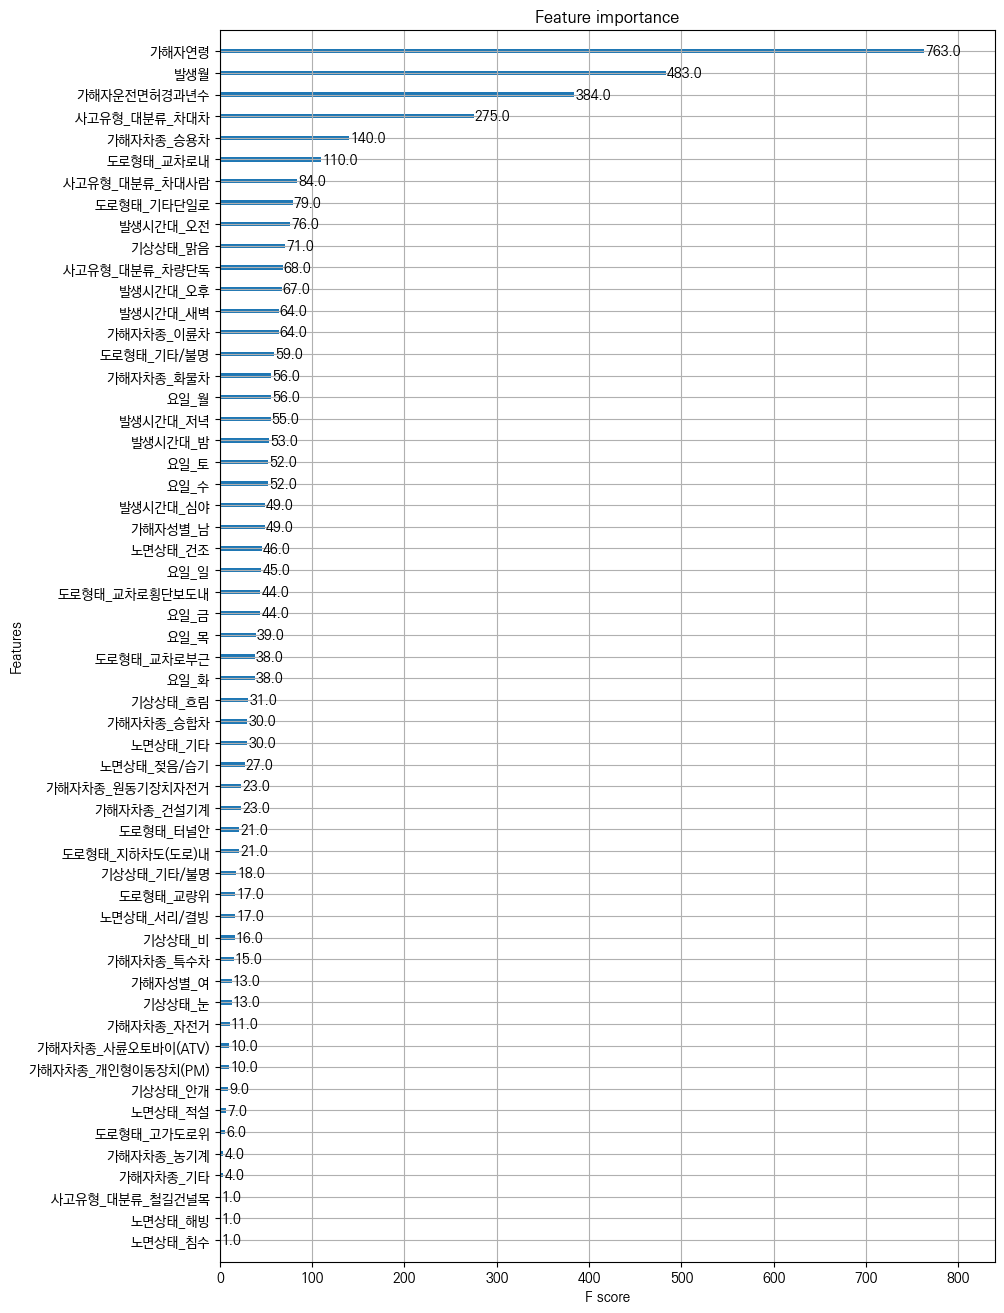

              Feature  Importance
0                 발생월       483.0
1               가해자연령       763.0
2         가해자운전면허경과년수       384.0
3                요일_금        44.0
4                요일_목        39.0
5                요일_수        52.0
6                요일_월        56.0
7                요일_일        45.0
8                요일_토        52.0
9                요일_화        38.0
10         기상상태_기타/불명        18.0
11             기상상태_눈        13.0
12            기상상태_맑음        71.0
13             기상상태_비        16.0
14            기상상태_안개         9.0
15            기상상태_흐림        31.0
16            노면상태_건조        46.0
17            노면상태_기타        30.0
18         노면상태_서리/결빙        17.0
19            노면상태_적설         7.0
20         노면상태_젖음/습기        27.0
21            노면상태_침수         1.0
22            노면상태_해빙         1.0
23      사고유형_대분류_차대사람        84.0
24       사고유형_대분류_차대차       275.0
25      사고유형_대분류_차량단독        68.0
26     사고유형_대분류_철길건널목         1.0
27            가해자성별_남        49.0
28            

In [448]:
# 중요도 계산 및 시각화
fig, ax = plt.subplots(figsize=(10, 16))
xgb.plot_importance(xgb_model, importance_type='weight',ax=ax)
plt.show()

# 중요도를 DataFrame으로 출력
importance_df = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='weight').items(),
                             columns=['Feature', 'Importance'])
print(importance_df)

##### SHAP

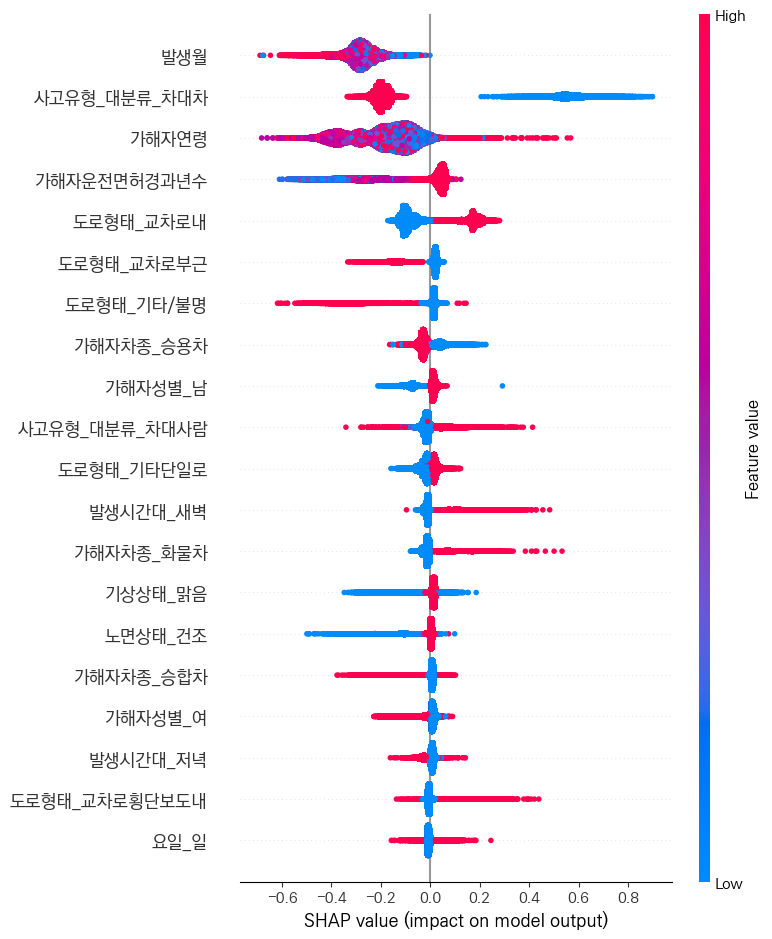

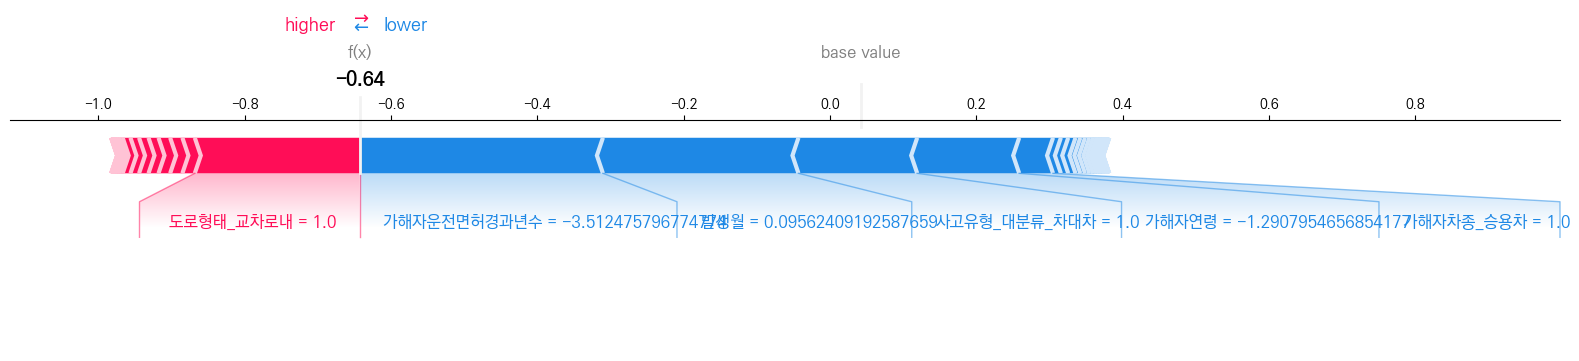

In [454]:
import shap

# 이미 학습한 XGBoost 모델을 사용
# SHAP Explainer 생성
explainer = shap.TreeExplainer(xgb_model)

# 테스트 데이터에 대한 SHAP 값을 계산
shap_values = explainer.shap_values(scaled_X_test)

# 1. 피처 중요도 시각화 (Summary plot)
shap.summary_plot(shap_values, scaled_X_test, feature_names=scaled_X_test.columns)

# 2. 각 피처가 개별 예측에 어떻게 기여하는지 분석 (Force plot)
# 테스트 데이터의 첫 번째 샘플에 대해 설명
shap.force_plot(explainer.expected_value, shap_values[0,:], scaled_X_test.iloc[0,:], matplotlib=True)


## Feature importance를 중점으로

In [4]:
cb_df = df.copy()

In [5]:
cb_df = cb_df[['TAAS사고번호','발생월', '발생시', '요일', '기상상태', '노면상태', '사고내용', '사고유형_대분류', '가해자성별', '가해자연령', '가해자운전면허경과년수',  '가해자차종', '도로형태',]]

In [6]:
cb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254664 entries, 0 to 1254663
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   TAAS사고번호     1254664 non-null  int64 
 1   발생월          1254664 non-null  int64 
 2   발생시          1254664 non-null  int64 
 3   요일           1254664 non-null  object
 4   기상상태         1254664 non-null  object
 5   노면상태         1254664 non-null  object
 6   사고내용         1254664 non-null  object
 7   사고유형_대분류     1254664 non-null  object
 8   가해자성별        1254664 non-null  object
 9   가해자연령        1254664 non-null  object
 10  가해자운전면허경과년수  1254664 non-null  object
 11  가해자차종        1254664 non-null  object
 12  도로형태         1254664 non-null  object
dtypes: int64(3), object(10)
memory usage: 124.4+ MB


In [7]:
cb_df['사고내용'].value_counts()

사고내용
경상      849390
중상      324128
부상신고     63331
사망       17815
Name: count, dtype: int64

In [10]:
cb_df

,TAAS사고번호,발생월,요일,기상상태,노면상태,사고내용,사고유형_대분류,가해자성별,가해자연령,가해자운전면허경과년수,가해자차종,도로형태,발생시간대
0,2020010100100080,1,수,흐림,건조,경상,차대차,남,60,8,승합차,교차로내,새벽
1,2020010100100060,1,수,맑음,건조,경상,차량단독,남,37,8,이륜차,교차로부근,새벽
2,2020010100100016,1,수,맑음,건조,경상,차대사람,남,54,8,승용차,기타단일로,심야
3,2020010100100001,1,수,맑음,건조,경상,차대사람,남,56,6,이륜차,기타단일로,심야
4,2020010100100021,1,수,맑음,건조,경상,차대차,남,62,8,승용차,기타단일로,심야
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254659,2023122000100377,12,수,기타/불명,건조,경상,차대사람,여,50,6,승용차,기타/불명,저녁
1254660,2023120700100440,12,목,맑음,건조,경상,차대차,여,32,6,승용차,기타/불명,저녁
1254661,2023071600100015,7,일,맑음,건조,경상,차대차,남,30,3,승용차,교차로부근,심야
1254662,2023112200100347,11,수,맑음,건조,경상,차대차,남,67,8,승용차,기타단일로,오후


In [9]:
#### 월은 만들어만 놓고 차후에 써보도록 하자
def mk_month_group(x):
    if 0 < x < 3 : return '겨울'
    elif 3 <= x < 6 : return '봄'
    elif 6 <= x < 9 : return '여름'
    elif 9 <= x < 12 : return '가을'
    else : return '겨울'
    
def mk_hour_group(hour):
    if 0 <= hour <= 3:
        return '심야'
    elif 4 <= hour <= 7:
        return '새벽'
    elif 8 <= hour <= 11:
        return '오전'
    elif 12 <= hour <= 15:
        return '오후'
    elif 16 <= hour <= 19:
        return '저녁'
    else:
        return '밤'

## data extract
mask1 = cb_df['가해자연령'] != '불명'
mask2 = ~cb_df['가해자운전면허경과년수'].isin(['없음','기타/불명'])
cb_df = cb_df[mask1&mask2]


#발생시 변환
time_group = ['새벽','오전','오후','저녁','밤','심야']
cb_df.loc[:, '발생시간대'] = cb_df['발생시'].apply(lambda x: mk_hour_group(x))
cb_df.loc[:,'발생시간대'] = pd.Categorical(cb_df['발생시간대'], categories=time_group)
cb_df.drop(columns = ['발생시'],inplace=True)


#가해자 연령 text -> int
cb_df.loc[:, '가해자연령'] = cb_df['가해자연령'].apply(lambda x: int(x.replace('세', '')))

#가해자 운전면허 경과년수 text -> int
license_order = {
    '1년미만' : 1,
    '2년미만' : 2,
    '3년미만' : 3,
    '4년미만' : 4,
    '5년미만' : 5,
    '10년미만' : 6,
    '15년미만' : 7,
    '15년이상' : 8,
}
cb_df.loc[:, '가해자운전면허경과년수'] = cb_df['가해자운전면허경과년수'].map(license_order)

cb_df.loc[:, '가해자연령'] = cb_df['가해자연령'].astype('int')
cb_df.loc[:, '가해자운전면허경과년수'] = cb_df['가해자운전면허경과년수'].astype('int')

/tmp/ipykernel_489862/4238261754.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb_df.loc[:, '발생시간대'] = cb_df['발생시'].apply(lambda x: mk_hour_group(x))
/tmp/ipykernel_489862/4238261754.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb_df.drop(columns = ['발생시'],inplace=True)


In [22]:
cb_df

,TAAS사고번호,발생월,요일,기상상태,노면상태,사고내용,사고유형_대분류,가해자성별,가해자연령,가해자운전면허경과년수,가해자차종,도로형태,발생시간대,사고내용_인코딩,사고내용_이진
0,2020010100100080,1,수,흐림,건조,경상,차대차,남,60,8,승합차,교차로내,새벽,1,0
1,2020010100100060,1,수,맑음,건조,경상,차량단독,남,37,8,이륜차,교차로부근,새벽,1,0
2,2020010100100016,1,수,맑음,건조,경상,차대사람,남,54,8,승용차,기타단일로,심야,1,0
3,2020010100100001,1,수,맑음,건조,경상,차대사람,남,56,6,이륜차,기타단일로,심야,1,0
4,2020010100100021,1,수,맑음,건조,경상,차대차,남,62,8,승용차,기타단일로,심야,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254659,2023122000100377,12,수,기타/불명,건조,경상,차대사람,여,50,6,승용차,기타/불명,저녁,1,0
1254660,2023120700100440,12,목,맑음,건조,경상,차대차,여,32,6,승용차,기타/불명,저녁,1,0
1254661,2023071600100015,7,일,맑음,건조,경상,차대차,남,30,3,승용차,교차로부근,심야,1,0
1254662,2023112200100347,11,수,맑음,건조,경상,차대차,남,67,8,승용차,기타단일로,오후,1,0


### Modeling

#### logger

In [26]:
logging.basicConfig(
    level=logging.INFO,  # 로그 레벨 설정
    format='%(asctime)s - %(levelname)s - %(message)s',  # 로그 포맷
    handlers=[
        logging.StreamHandler(),  # 콘솔(노트북 출력)으로 로그 전송
        logging.FileHandler("model_training.log")  # 파일로 로그 저장
    ]
)
logger = logging.getLogger()

logger.info("로깅 설정 완료.")

2024-10-07 11:31:20,392 - INFO - 로깅 설정 완료.


#### Ray

In [27]:
# Ray를 초기화합니다. 이미 초기화된 경우 무시하도록 설정합니다.
ray.init(ignore_reinit_error=True)
logger.info("Ray 초기화 완료.")

2024-10-07 11:31:20,402	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
2024-10-07 11:31:20,402 - INFO - Ray 초기화 완료.


#### Target Encoding

In [28]:
# 5. 타겟 변수 인코딩
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

logger.info("Step 2: 타겟 변수 인코딩 시작.")

# 순서형 4-클래스 타겟 인코딩 (0,1,2,3)
target_mapping = {'부상신고': 0, '경상': 1, '중상': 2, '사망': 3}
cb_df['사고내용_인코딩'] = cb_df['사고내용'].map(target_mapping)

# 이진 타겟 생성: '부상신고'와 '경상'을 0, '중상'과 '사망'을 1로 매핑
binary_target_mapping = {'부상신고': 0, '경상': 0, '중상': 1, '사망': 1}
cb_df['사고내용_이진'] = cb_df['사고내용'].map(binary_target_mapping)

logger.info("Step 2: 타겟 변수 인코딩 완료.")
logger.info(f"타겟 변수 인코딩 결과:\n{cb_df[['사고내용', '사고내용_인코딩', '사고내용_이진']].head()}")

2024-10-07 11:31:20,405 - INFO - Step 2: 타겟 변수 인코딩 시작.
2024-10-07 11:31:20,450 - INFO - Step 2: 타겟 변수 인코딩 완료.
2024-10-07 11:31:20,457 - INFO - 타겟 변수 인코딩 결과:
  사고내용  사고내용_인코딩  사고내용_이진
0   경상         1        0
1   경상         1        0
2   경상         1        0
3   경상         1        0
4   경상         1        0


#### Feature Encoding

In [29]:
# 6. 특징 변수 인코딩 및 스케일링
logger.info("Step 3: 특징 변수 인코딩 및 스케일링 시작.")

# 범주형 변수와 수치형 변수 구분
categorical_features = [
    '요일', '기상상태', '노면상태', '사고유형_대분류',
    '가해자성별', '가해자연령', '가해자운전면허경과년수',
    '가해자차종', '도로형태', '발생시간대'
]
numerical_features = ['발생월']

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

logger.info("Step 3: 특징 변수 인코딩 및 스케일링 완료.")

2024-10-07 11:31:20,460 - INFO - Step 3: 특징 변수 인코딩 및 스케일링 시작.
2024-10-07 11:31:20,460 - INFO - Step 3: 특징 변수 인코딩 및 스케일링 완료.


#### Data Split

In [30]:
# 7. 데이터 분할
logger.info("Step 4: 데이터 분할 시작.")

# 특징 변수 (타겟 변수 제외)
X = cb_df.drop(['TAAS사고번호', '사고내용', '사고내용_인코딩', '사고내용_이진'], axis=1)
y_ordinal = cb_df['사고내용_인코딩']
y_binary = cb_df['사고내용_이진']

# 순서형 타겟을 위한 데이터 분할
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(
    X, y_ordinal, test_size=0.2, random_state=42, stratify=y_ordinal
)

# 이진 타겟을 위한 데이터 분할
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

logger.info("Step 4: 데이터 분할 완료.")
logger.info(f" - 순서형 타겟: 학습 데이터 크기 = {X_train_ord.shape}, 테스트 데이터 크기 = {X_test_ord.shape}")
logger.info(f" - 이진 타겟: 학습 데이터 크기 = {X_train_bin.shape}, 테스트 데이터 크기 = {X_test_bin.shape}")

2024-10-07 11:34:18,386 - INFO - Step 4: 데이터 분할 시작.
2024-10-07 11:34:18,867 - INFO - Step 4: 데이터 분할 완료.
2024-10-07 11:34:18,867 - INFO -  - 순서형 타겟: 학습 데이터 크기 = (937167, 11), 테스트 데이터 크기 = (234292, 11)
2024-10-07 11:34:18,868 - INFO -  - 이진 타겟: 학습 데이터 크기 = (937167, 11), 테스트 데이터 크기 = (234292, 11)


#### Class Unbalance

In [31]:
# 8. 클래스 불균형 처리
logger.info("Step 5: 클래스 불균형 처리 시작.")

# SMOTE 객체 생성
smote_ord = SMOTE(random_state=42, n_jobs=-1)
smote_bin = SMOTE(random_state=42, n_jobs=-1)

logger.info(" - SMOTE 객체 생성 완료.")
logger.info("Step 5: 클래스 불균형 처리 완료.")

2024-10-07 11:34:24,405 - INFO - Step 5: 클래스 불균형 처리 시작.
2024-10-07 11:34:24,406 - INFO -  - SMOTE 객체 생성 완료.
2024-10-07 11:34:24,406 - INFO - Step 5: 클래스 불균형 처리 완료.


#### Ordinal Classfication

In [ ]:
# 9.1. 순서형 4-클래스 분류 모델 학습
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_absolute_error, mean_squared_error
import numpy as np

logger.info("Step 6: 모델 정의 및 학습 시작.")

# 분류 모델 목록
classifiers_ord = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
}

# 모델별 결과 저장 딕셔너리
results_ord = {}

# Ray 원격 함수 정의
@ray.remote(num_cpus=16, memory= 100 * 1024 * 1024 * 1024)  # 예시: 4 CPU, 16GB 메모리 (시스템에 맞게 조정)
def train_and_evaluate_model_ord(name, clf, X_train, y_train, X_test, y_test, target_names, preprocessor, smote):
    try:
        logger.info(f"Training {name} for Ordinal Classification...")
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', smote),
            ('classifier', clf)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, target_names=target_names)
        logger.info(f"{name} 학습 및 예측 완료.")
        return {
            'name': name,
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': report,
            'model': pipeline
        }
    except Exception as e:
        logger.error(f"Error in {name}: {e}")
        return {
            'name': name,
            'error': str(e)
        }

# 원격 작업 스케줄링
remote_tasks_ord = [
    train_and_evaluate_model_ord.remote(
        name, clf, X_train_ord, y_train_ord, X_test_ord, y_test_ord, list(target_mapping.keys()), preprocessor, smote_ord
    )
    for name, clf in classifiers_ord.items()
]

# 결과 수집
results_ord_ray = ray.get(remote_tasks_ord)

# 결과 저장 및 로깅
for result in results_ord_ray:
    if 'error' not in result:
        results_ord[result['name']] = {
            'model': result['model'],
            'accuracy': result['accuracy'],
            'f1_score': result['f1_score'],
            'classification_report': result['classification_report']
        }
        logger.info(f"=== {result['name']} (Ordinal Classification) ===")
        logger.info(f"Accuracy: {result['accuracy']:.4f}")
        logger.info(f"F1 Score: {result['f1_score']:.4f}")
        logger.info(result['classification_report'])
        logger.info("\n")
    else:
        logger.error(f"=== {result['name']} (Ordinal Classification) ===")
        logger.error(f"Error: {result['error']}")
        logger.error("\n")

logger.info("Step 6.1: 순서형 4-클래스 분류 모델 학습 및 평가 완료.")

2024-10-07 11:34:48,406 - INFO - Step 6: 모델 정의 및 학습 시작.


#### Binomial Classification

In [ ]:
# 9.2. 이진 분류 모델 학습
logger.info("Step 6.2: 이진 분류 모델 학습 시작.")

# 분류 모델 목록 (이진 타겟용)
classifiers_bin = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

# 모델별 결과 저장 딕셔너리
results_bin = {}

# Ray 원격 함수 정의
@ray.remote(num_cpus=4, memory=16 * 1024 * 1024 * 1024)  # 예시: 4 CPU, 16GB 메모리
def train_and_evaluate_model_bin(name, clf, X_train, y_train, X_test, y_test, preprocessor, smote):
    try:
        logger.info(f"Training {name} for Binary Classification...")
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', smote),
            ('classifier', clf)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, target_names=['0', '1'])
        logger.info(f"{name} 학습 및 예측 완료.")
        return {
            'name': name,
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': report,
            'model': pipeline
        }
    except Exception as e:
        logger.error(f"Error in {name}: {e}")
        return {
            'name': name,
            'error': str(e)
        }

# 원격 작업 스케줄링
remote_tasks_bin = [
    train_and_evaluate_model_bin.remote(
        name, clf, X_train_bin, y_train_bin, X_test_bin, y_test_bin, preprocessor, smote_bin
    )
    for name, clf in classifiers_bin.items()
]

# 결과 수집
results_bin_ray = ray.get(remote_tasks_bin)

# 결과 저장 및 로깅
for result in results_bin_ray:
    if 'error' not in result:
        results_bin[result['name']] = {
            'model': result['model'],
            'accuracy': result['accuracy'],
            'f1_score': result['f1_score'],
            'classification_report': result['classification_report']
        }
        logger.info(f"=== {result['name']} (Binary Classification) ===")
        logger.info(f"Accuracy: {result['accuracy']:.4f}")
        logger.info(f"F1 Score: {result['f1_score']:.4f}")
        logger.info(result['classification_report'])
        logger.info("\n")
    else:
        logger.error(f"=== {result['name']} (Binary Classification) ===")
        logger.error(f"Error: {result['error']}")
        logger.error("\n")

logger.info("Step 6.2: 이진 분류 모델 학습 및 평가 완료.")

#### Regression

In [ ]:
# 9.3. 회귀 모델 학습
logger.info("Step 6.3: 회귀 모델 학습 시작.")

# 회귀 모델 목록
regressors = {
    'Ridge Regression': Ridge(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42, n_jobs=-1)
}

# 회귀 모델별 결과 저장 딕셔너리
regression_results = {}

# Ray 원격 함수 정의
@ray.remote(num_cpus=4, memory=16 * 1024 * 1024 * 1024)  # 예시: 4 CPU, 16GB 메모리
def train_and_evaluate_regressor(name, reg, X_train, y_train, X_test, y_test, preprocessor, smote):
    try:
        logger.info(f"Training {name} for Regression...")
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', smote),
            ('regressor', reg)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        logger.info(f"{name} 학습 및 예측 완료.")
        return {
            'name': name,
            'MAE': mae,
            'RMSE': rmse,
            'model': pipeline
        }
    except Exception as e:
        logger.error(f"Error in {name}: {e}")
        return {
            'name': name,
            'error': str(e)
        }

# 원격 작업 스케줄링
remote_tasks_reg = [
    train_and_evaluate_regressor.remote(
        name, reg, X_train_ord, y_train_ord, X_test_ord, y_test_ord, preprocessor, smote_ord
    )
    for name, reg in regressors.items()
]

# 결과 수집
regression_results_ray = ray.get(remote_tasks_reg)

# 결과 저장 및 로깅
for result in regression_results_ray:
    if 'error' not in result:
        regression_results[result['name']] = {
            'model': result['model'],
            'MAE': result['MAE'],
            'RMSE': result['RMSE']
        }
        logger.info(f"=== {result['name']} (Regression) ===")
        logger.info(f"MAE: {result['MAE']:.4f}")
        logger.info(f"RMSE: {result['RMSE']:.4f}")
        logger.info("\n")
    else:
        logger.error(f"=== {result['name']} (Regression) ===")
        logger.error(f"Error: {result['error']}")
        logger.error("\n")

logger.info("Step 6.3: 회귀 모델 학습 및 평가 완료.")


#### Feature Importance

In [ ]:
# 10. 피처 중요도 추출 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns

logger.info("Step 7: 피처 중요도 추출 및 시각화 시작.")

# 범주형 및 수치형 특성 목록 재확인
categorical_features = [
    '요일', '기상상태', '노면상태', '사고유형_대분류',
    '가해자성별', '가해자연령', '가해자운전면허경과년수',
    '가해자차종', '도로형태', '발생시간대'
]
numerical_features = ['발생월']

# 모든 피처 이름
ohe_ord = preprocessor.named_transformers_['cat']
if hasattr(ohe_ord, 'get_feature_names_out'):
    ohe_features_ord = ohe_ord.get_feature_names_out(categorical_features)
else:
    ohe_features_ord = ohe_ord.get_feature_names(categorical_features)
all_features_ord = numerical_features + list(ohe_features_ord)

# 10.1. 순서형 4-클래스 분류 모델의 피처 중요도
logger.info("Step 7.1: 순서형 4-클래스 분류 모델 피처 중요도 추출 중...")
if results_ord:
    # 가장 성능이 좋은 순서형 모델 선택 (F1 Score 기준)
    best_model_ord_name = max(results_ord, key=lambda x: results_ord[x]['f1_score'])
    best_model_ord = results_ord[best_model_ord_name]['model']
    
    logger.info(f"가장 성능이 좋은 순서형 모델: {best_model_ord_name}")
    
    # 피처 중요도 추출
    if hasattr(best_model_ord.named_steps['classifier'], 'feature_importances_'):
        importances = best_model_ord.named_steps['classifier'].feature_importances_
        feature_importance = pd.Series(importances, index=all_features_ord).sort_values(ascending=False)
        
        # 상위 20개 피처 시각화
        logger.info("순서형 모델 피처 중요도 시각화 중...")
        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
        plt.title('Feature Importance (Ordinal Classification)')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
        logger.info("순서형 모델 피처 중요도 시각화 완료.")
    else:
        logger.warning("선택한 순서형 모델에서 피처 중요도를 추출할 수 없습니다.")
else:
    logger.warning("순서형 분류 모델 결과가 없습니다.")

# 10.2. 이진 분류 모델의 피처 중요도
logger.info("Step 7.2: 이진 분류 모델 피처 중요도 추출 중...")
if results_bin:
    # 가장 성능이 좋은 이진 모델 선택 (F1 Score 기준)
    best_model_bin_name = max(results_bin, key=lambda x: results_bin[x]['f1_score'])
    best_model_bin = results_bin[best_model_bin_name]['model']
    
    logger.info(f"가장 성능이 좋은 이진 모델: {best_model_bin_name}")
    
    if hasattr(best_model_bin.named_steps['classifier'], 'feature_importances_'):
        importances = best_model_bin.named_steps['classifier'].feature_importances_
        feature_importance = pd.Series(importances, index=all_features_ord).sort_values(ascending=False)
        
        # 상위 20개 피처 시각화
        logger.info("이진 모델 피처 중요도 시각화 중...")
        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
        plt.title('Feature Importance (Binary Classification)')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
        logger.info("이진 모델 피처 중요도 시각화 완료.")
    else:
        logger.warning("선택한 이진 모델에서 피처 중요도를 추출할 수 없습니다.")
else:
    logger.warning("이진 분류 모델 결과가 없습니다.")

# 10.3. 회귀 모델의 피처 중요도
logger.info("Step 7.3: 회귀 모델 피처 중요도 추출 중...")
if regression_results:
    # 가장 성능이 좋은 회귀 모델 선택 (MAE 기준)
    best_regressor_name = min(regression_results, key=lambda x: regression_results[x]['MAE'])
    best_regressor = regression_results[best_regressor_name]['model']
    
    logger.info(f"가장 성능이 좋은 회귀 모델: {best_regressor_name}")
    
    if hasattr(best_regressor.named_steps['regressor'], 'coef_'):
        coefficients = best_regressor.named_steps['regressor'].coef_
        feature_importance = pd.Series(coefficients, index=all_features_ord).sort_values(key=abs, ascending=False)
        
        # 상위 20개 피처 시각화
        logger.info("회귀 모델 피처 중요도 시각화 중...")
        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
        plt.title('Feature Coefficients (Regression)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
        logger.info("회귀 모델 피처 중요도 시각화 완료.")
    else:
        logger.warning("선택한 회귀 모델에서 피처 중요도를 추출할 수 없습니다.")
else:
    logger.warning("회귀 모델 결과가 없습니다.")

logger.info("Step 7: 피처 중요도 추출 및 시각화 완료.")